**Deep Learning AA 2023/2024**
** **
Teachers:\
Fabrizio Silvestri (fsilvestri@diag.uniroma1.it)\
Antonio Purificato (antonio.purificato@uniroma1.it)\
Farooq Wani (wani@diag.uniroma1.it)\
Maria Sofia Bucarelli (bucarelli.diag@uniroma1.it) \


![](https://drive.google.com/file/uc?id=us1J8vmwqu6DM58Sj6r-Qh9u9ibKPzuDsSq)

In [ ]:
%%capture
!pip install pytorch-lightning #  install pytorch lightining

In [ ]:
#@title Import dependecies
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import functional
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title Reproducibility
pl.seed_everything(0)

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

# **ResNet**


![](https://drive.google.com/uc?id=1BTf1kJeAWnDUnIoAxaizF4MJk3a0hTVt)

**Degradation problem**: the 56-layer plain net has higher training error throughout the whole training procedure, even though the solution space of the 20-layer plain network is a subspace of that of the 56-layer one.




Training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer “plain” networks. The deeper network has higher training error, and thus test error.

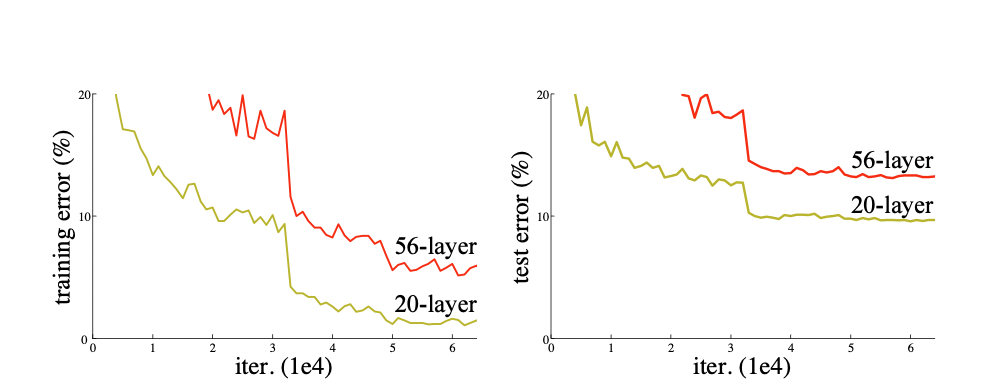

The degradation problem is a counterintuitive phenomena.
Intuitively we imagine that the added layers can be constructed as identity mapping,  a deeper model should have training error no greater than its shallower counter- part.

 The degradation problem suggests that the solvers might have difficulties in approximating identity mappings by multiple nonlinear layers.


In [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) He, Zhang, Ren and Sun addressed this problem,  at the heart of their proposed residual network (ResNet) is the idea that every additional layer should more easily contain the identity function as one of its elements.


 With the residual learning reformulation, if identity mappings are optimal, the solvers may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings.


##**Residual Blocks**

In this paper, they address the degradation problem by introducing a deep residual learning framework. Instead of hoping each few stacked layers directly fit a desired underlying mapping, they explicitly let these layers fit a residual mapping.

Formally, denoting the desired underlying mapping as $\mathcal{H}(x)$, we let the stacked nonlinear layers fit another mapping of $\mathcal{F}(x) := \mathcal{H}(x) − x$. The original mapping is recast into $\mathcal{F}(x)+x$. We hypothesize that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers.

The formulation of $\mathcal{F}(x) + x$ can be realized by feedforward neural networks with “shortcut connections”.

The shortcut connections simply perform identity mapping, and their outputs are added to the outputs of the stacked layers. Identity shortcut connections add neither extra parameter nor computational complexity.


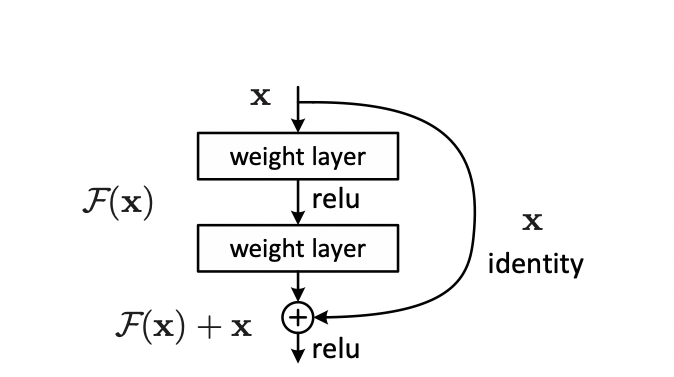

Formally, in this paper we consider a building block defined as:
$$ y = \mathcal{F}(x, {W_i }) + x$$
The function $\mathcal{F}(x, {W_i })$ represents the residual mapping to be learned. For the example the network in the above figure has two layers,  $\mathcal{F} = W_2 \sigma (W_1x)$ in which $\sigma$ denotes
ReLU and the biases are omitted for simplifying notations. The operation $\mathcal{F} + x$ is performed by a shortcut connection and element-wise addition. We adopt the second nonlinearity after the addition.
The shortcut connections above introduce neither extra parameter nor computation complexity.


The dimensions of $x$ and $\mathcal{F}$ must be equal. If this is not the case (e.g., when changing the input/output channels), we can perform a linear projection $W_s$ by the shortcut connections to match the dimensions:
$$y = \mathcal{F}(x, {W_i }) + W_s x$$
We can also use a square matrix $W_s$ even when the dimensions of $x$ and $\mathcal{F}$ are equal. But the authors shown by experiments that the identity mapping is sufficient for addressing the degradation problem and is economical.

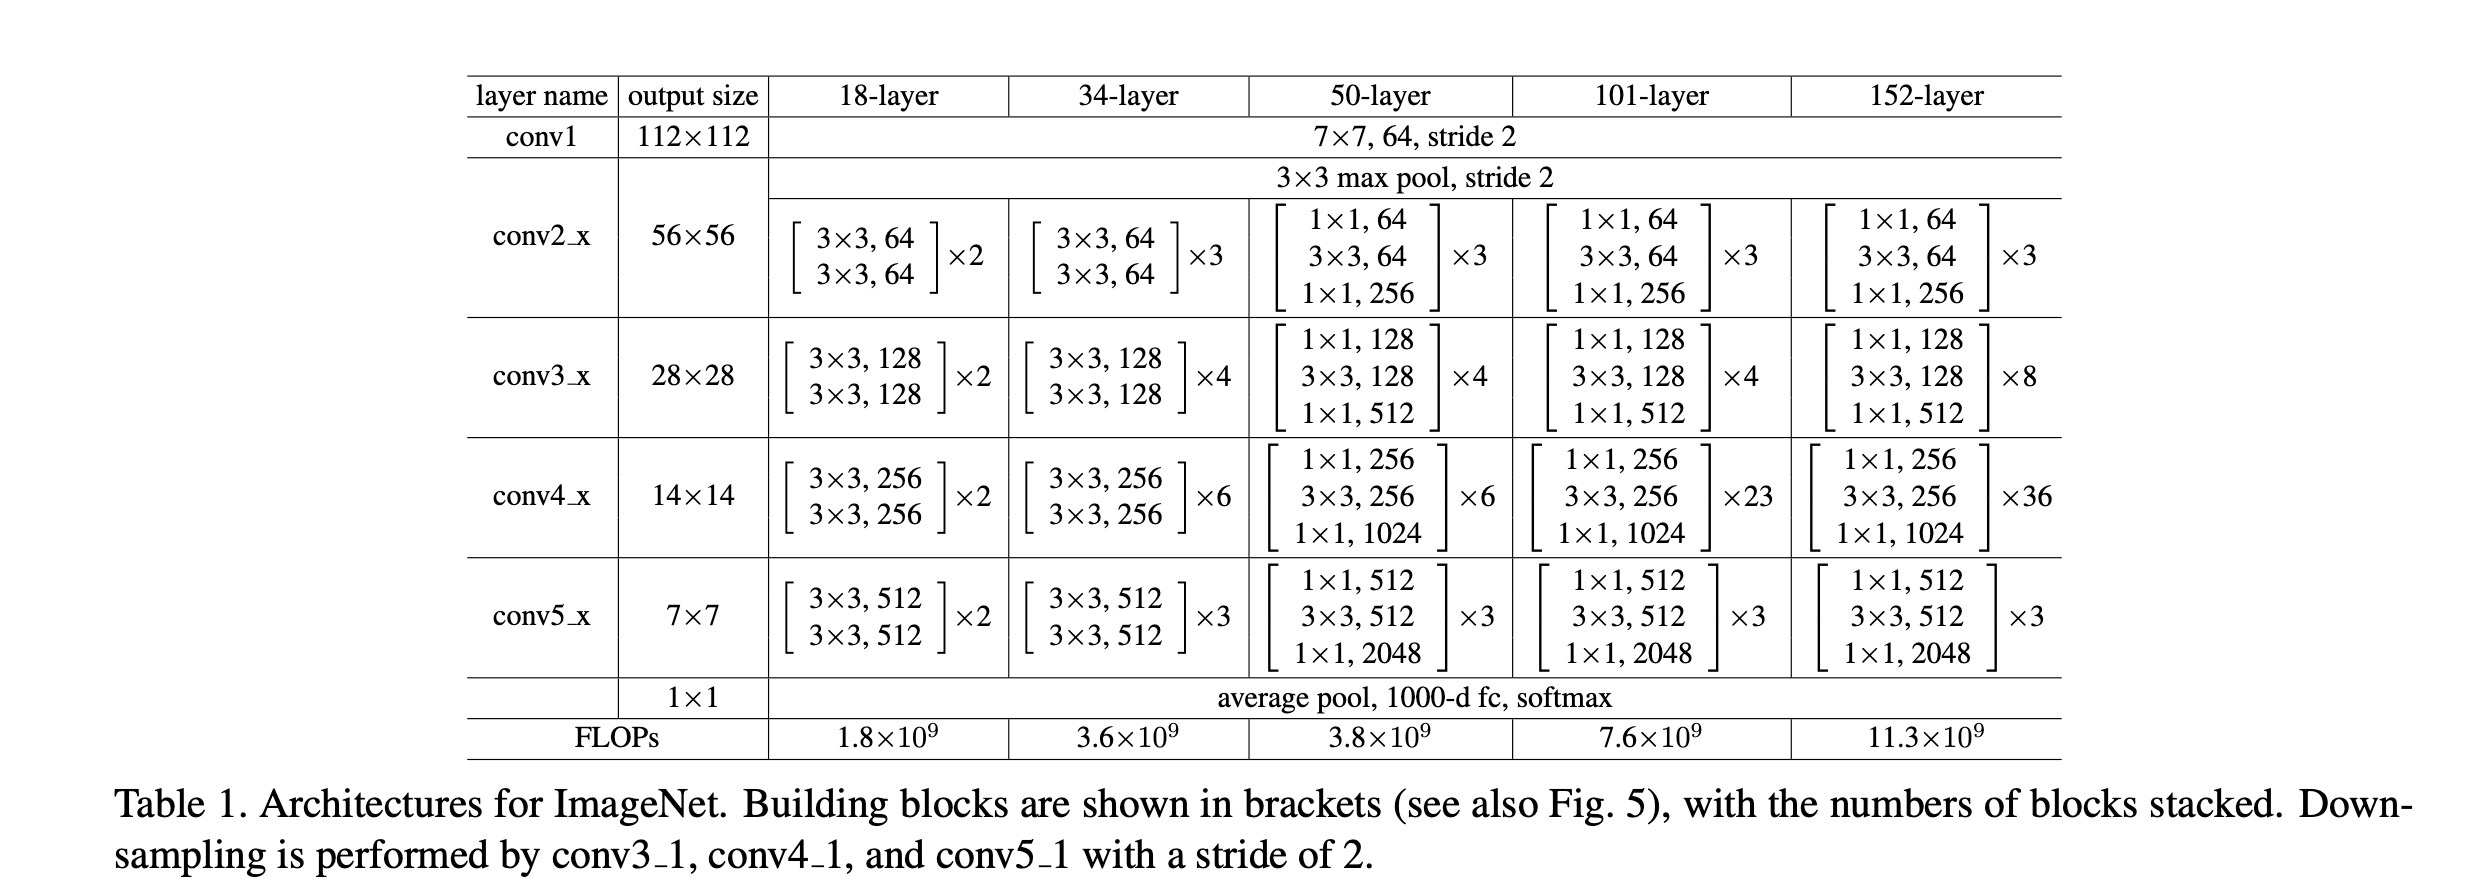

ResNet follows VGG's full  3×3  convolutional layer design. The residual block has two  3×3  convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function.
Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional  1×1  convolutional layer to transform the input into the desired shape for the addition operation.

A deeper residual function $\mathcal{F}$ for ImageNet.

Left: a building block (on 56×56 feature maps) for ResNet- 34.     Right: a “bottleneck” building block for ResNet-50/101/152.

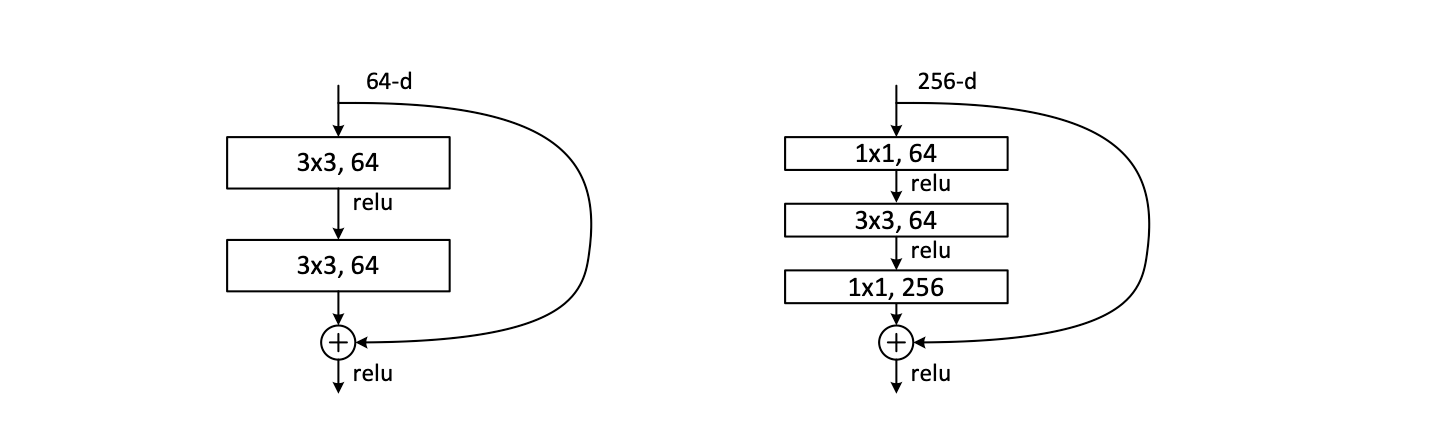

###**Exercise to do together**

Write a class for a single block inheriting from pl.LightningModule class or torch.nn.Module class.
The structure of the block should be as in the above figure: two convolutional layers followed by batch normalization layers and the residual layer.

Use [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)

In [ ]:
class FirstBlock(pl.LightningModule):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(self).__init__()
    self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(hidden_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(hidden_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = nn.functional.relu(x)
    ...
    x += identity

    return(x)



**Deeper Bottleneck Architectures**: Deeper non-bottleneck ResNets also gain accuracy from increased depth but are not as economical as the bottleneck ResNets. So the usage of bottleneck designs is mainly due to practical considerations. We further note that the degradation problem of plain nets is also witnessed for the bottleneck designs.

## ResNet implementation

In [ ]:
class Block(pl.LightningModule):
  """The Residual block of ResNet."""
  def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

  def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

A LightningModule organizes your PyTorch code into 6 sections:

* Initialization (__init__ and setup()).
* Train Loop (training_step())
* Validation Loop (validation_step())
* Test Loop (test_step())
* Prediction Loop (predict_step())
* Optimizers and LR Schedulers (configure_optimizers())

In [ ]:
class ResNet(pl.LightningModule):
    def __init__(self, num_layers, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], print("Number of layers has to be 18, 34, 50, 101, or 152 ")
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(Block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(Block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss =  F.cross_entropy(y_hat, y)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)
        output = dict({
          'test_loss': loss,
          'test_acc': torch.tensor(acc),
           })
        return output


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
model = ResNet(18, 3, 10)
print(model)

# Loading Data


#CIFAR10


First way to build the dataloader

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


# Define the split ratio for validation
validation_ratio = 0.01  # Adjust this ratio as needed

# Split the trainset into training and validation sets
train_size = int((1.0 - validation_ratio) * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


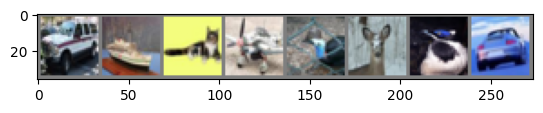

  car  ship   cat plane  bird  deer  bird   car


In [ ]:
# get some random training images
dataiter = next(iter(train_loader))
images, labels = dataiter



# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


##Pretrained ResNet

In [ ]:
from pytorch_lightning import LightningDataModule, LightningModule
import torchvision.transforms as transforms


### Resnet
Modify the pre-existing Resnet architecture from TorchVision. The pre-existing architecture is based on ImageNetimages (224x224) as input. So we need to modify it for CIFAR10 images (32x32).

https://pytorch.org/vision/stable/models.html

In [ ]:
import torchvision.models as models
from torchmetrics import Accuracy #where is this module?
from torch.nn.functional import cross_entropy
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from pytorch_lightning.loggers import CSVLogger
import os
import pandas as pd
import seaborn as sn
from torchmetrics import Accuracy

accuracy = Accuracy(task="multiclass",num_classes=10)


class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr


        self.model = models.resnet50(weights="IMAGENET1K_V2")

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, inputs):
        return self.model(inputs)


    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        out = self(x)

        #preds = self.model(x)
        #loss = CrossEntropyLoss()
        loss = F.cross_entropy(out, y)

        #myloss = loss(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        #self.log('train_acc', acc)
        return loss



    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        # return optimizer
        optimizer = Adam(self.model.fc.parameters(), lr=self.hparams.lr)
        return optimizer

## Manual Optimization

For advanced research topics like reinforcement learning, sparse coding, or GAN research, it may be desirable to manually manage the optimization process, especially when dealing with multiple optimizers at the same time.

In this mode, Lightning will handle only accelerator, precision and strategy logic. The users are left with optimizer.zero_grad(), gradient accumulation, optimizer toggling, etc..

To manually optimize, do the following:

Set self.automatic_optimization=False in your LightningModule’s __init__.
Use the following functions and call them manually:
self.optimizers() to access your optimizers (one or multiple)
optimizer.zero_grad() to clear the gradients from the previous training step
self.manual_backward(loss) instead of loss.backward()
optimizer.step() to update your model parameters
self.toggle_optimizer() and self.untoggle_optimizer() if needed

If you rember this is the traing loop in pytorch:

In [ ]:
# put model in train mode and enable gradient calculation
model.train()
torch.set_grad_enabled(True)

for batch_idx, batch in enumerate(train_dataloader):
    loss = training_step(batch, batch_idx)

    # clear gradients
    optimizer.zero_grad()

    # backward
    loss.backward()

    # update parameters
    optimizer.step()

In [ ]:
from lightning.pytorch import LightningModule


class MyModel(LightningModule):
    def __init__(self):
        super().__init__()
        # Important: This property activates manual optimization.
        self.automatic_optimization = False

    def training_step(self, batch, batch_idx):
        opt = self.optimizers()
        opt.zero_grad()
        loss = self.compute_loss(batch)
        self.manual_backward(loss)
        opt.step()

### Gradient Accumulation

You can accumulate gradients over batches similarly to accumulate_grad_batches argument in Trainer for automatic optimization. To perform gradient accumulation with one optimizer after every N steps, you can do as such.

In [ ]:
def __init__(self):
    super().__init__()
    self.automatic_optimization = False


def training_step(self, batch, batch_idx):
    opt = self.optimizers()

    # scale losses by 1/N (for N batches of gradient accumulation)
    loss = self.compute_loss(batch) / N
    self.manual_backward(loss)

    # accumulate gradients of N batches
    if (batch_idx + 1) % N == 0:
        opt.step()
        opt.zero_grad()

## Automatic Optimization

In [ ]:
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint


GPUS = min(1, torch.cuda.device_count())
if GPUS: BATCH_SIZE = 64
else: BATCH_SIZE=8
classifier = ImageClassifier()


### Callbacks

Lightning has a callback system to execute them when needed. Callbacks should capture NON-ESSENTIAL logic that is NOT required for your lightning module to run.

Lightning has a few [built-in callbacks.](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html#built-in-callbacks)

Some we will use most probably:
* [EarlyStopping](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.EarlyStopping.html#lightning.pytorch.callbacks.EarlyStopping)
*  [ModelCheckpoint ](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelCheckpoint.html#lightning.pytorch.callbacks.ModelCheckpoint)

* [ModelPruning](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.callbacks.ModelPruning.html#lightning.pytorch.callbacks.ModelPruning)

In [ ]:


class MyPrintingCallback(pl.Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is starting")

    def on_train_end(self, trainer, pl_module):
        print(trainer.current_epoch)
        print("Training is ending")




Other example of

`on_train_batch_start(trainer, pl_module, outputs, batch, batch_idx)`: Called when the train batch begins.

`on_validation_epoch_end(trainer, pl_module)`: Called when the val epoch ends.

`on_test_epoch_start(trainer, pl_module)`: Called when the test epoch starts.

`on_train_start(trainer, pl_module)`: Called when the train begins.

`on_validation_end(trainer, pl_module)`: Called when the validation loop ends

`on_exception (trainer, pl_module, exception)`: Called when any trainer execution is interrupted by an exception.

`on_before_backward(trainer, pl_module)`: Called before loss.backward().

`on_after_backward(trainer, pl_module)`: Called after loss.backward() and before optimizers are stepped.

`on_before_optimizer_step(trainer, pl_module, optimizer)`


`load_state_dictstate_dict`: Called when loading a checkpoint, implement to reload callback state given callback’s

`on_load_checkpoint(trainer, pl_module, checkpoint)`: Called when loading a model checkpoint, use to reload state.

`on_save_checkpoint(trainer, pl_module, checkpoint)`:
Called when saving a checkpoint to give you a chance to store anything else you might want to save.

Always, Return type: None


Different:

`state_dict()`:
Called when saving a checkpoint, implement to generate callback’s state_dict.

Return type:
Dict[str, Any]

Returns:
A dictionary containing callback state.

In [ ]:

class EmbeddingVisualizerCallback(pl.Callback):
    def __init__(self, dataloader, show_plot=True, save_path=None,num_batches_to_process=10 ):
        super().__init__()
        self.dataloader = dataloader
        self.show_plot = show_plot
        self.save_path =  save_path
        self.num_batches_to_process = num_batches_to_process


    def on_train_epoch_end(self, trainer, pl_module):
        print("hello everyone, this is epoch:", trainer.current_epoch, "let's now print some plots")
        # Extract embeddings and labels from the dataset
        embeddings, labels = self._get_embeddings_and_labels(trainer, pl_module)
        # Perform t-SNE to reduce dimensions to 3D
        tsne = TSNE(n_components=3, random_state=42)
        embeddings_3d = tsne.fit_transform(embeddings)

        # Plot the embeddings in 3D
        self._plot_3d_embeddings(embeddings_3d, labels)

    def _get_embeddings_and_labels(self, trainer, pl_module):
        embeddings = []
        labels = []

        with torch.no_grad():
            pl_module.eval()
            for batch_idx, batch in enumerate(test_loader):
                if batch_idx >= self.num_batches_to_process:
                    break
                inputs, targets = batch
                if torch.cuda.is_available():
                    inputs, targets = inputs.to(trainer.device), targets.to(trainer.device)
                embeddings_batch = pl_module(inputs).cpu().numpy()
                embeddings.extend(embeddings_batch)
                labels.extend(targets.cpu().numpy())

        return np.array(embeddings), np.array(labels)

    def _plot_3d_embeddings(self, embeddings, labels):

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=labels, cmap='viridis')
        ax.set_title("t-SNE 3D Embeddings")

        if self.show_plot:
            plt.show()

        epoch_number = trainer.current_epoch #we get the number of epoch
        plt.savefig(self.save_path+"/embedding_"+str(epoch_number)+".png")
        print(f"Saved the 3D embeddings plot to {self.save_path}")
        plt.close()


In [ ]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Metric to monitor for saving the best model
    mode='min',          # Mode can be 'min' for loss or 'max' for accuracy
    dirpath='checkpoints/',  # Directory to save the checkpoints
    filename='model-{epoch:02d}-{val_loss:.2f}',  # Checkpoint file format
    save_top_k=1,  # Save the best model only
    verbose=True
)

In [ ]:
!mkdir "Embeddings"

In [ ]:
# Assuming you have a LightningModule, train_dataloader, and valid_dataloader


trainer = pl.Trainer(max_epochs=2,
                     callbacks=[TQDMProgressBar(refresh_rate=20),
                                EmbeddingVisualizerCallback(dataloader=train_loader, save_path= "Embeddings"),
                                MyPrintingCallback(),
                                checkpoint_callback],
                     logger=CSVLogger(save_dir="logs/"))

trainer.fit(classifier, train_loader, val_loader )


In [ ]:
trainer.test(classifier,test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


[Loggers](https://lightning.ai/docs/pytorch/stable/extensions/logging.html )

Lightning offers automatic log functionalities for logging scalars, or manual logging for anything else.


Use the log() or log_dict() methods to log from anywhere in a LightningModule and callbacks.

In the training we also passed the` Logger`, in particular `CSVLogger`. This log to local file system in yaml and CSV format. See [CSV logger](https://lightning.ai/docs/pytorch/stable/extensions/generated/lightning.pytorch.loggers.CSVLogger.html)

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")


In [ ]:
metrics

,train_loss,step,epoch,val_loss,val_acc
0,1.566379,49,0,NaN,NaN
1,NaN,62,0,2.885446,0.258
2,2.121617,99,1,NaN,NaN
3,NaN,125,1,1.434633,0.674


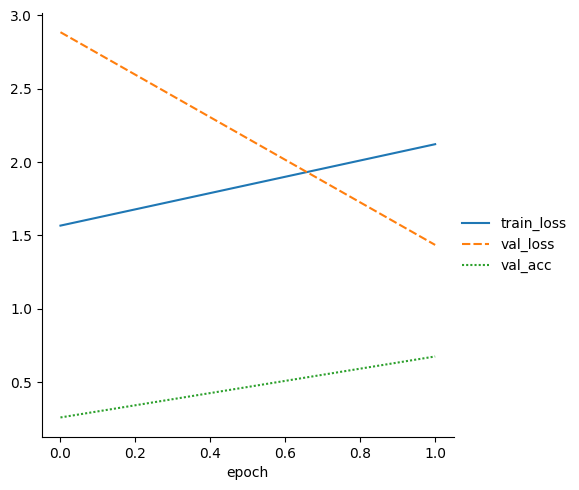

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")

In [ ]:
best_model = ImageClassifier.load_from_checkpoint("/content/checkpoints/model-epoch=01-val_loss=1.43.ckpt")

# Now we can use the best model for inference
best_model.eval()

FileNotFoundError: ignored